### Исследование пользователей сервиса "Яндекс.Афиша".

Проводится исследование пользователей сервиса "Яндекс.Афиша" в целях оптимизации маркетинговых затрат. В рамках анализа необходимо изучить следующие моменты: 

-	как люди пользуются продуктом,
-	когда они начинают покупать,
-	сколько денег приносит каждый клиент
-	когда клиент окупается.
 
Для анализа были предоставлены данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:

-	лог сервера с данными о посещениях сайта Яндекс.Афиши,
-	выгрузка всех заказов за этот период,
-	статистика рекламных расходов.


<a href='#info1'>1) Общая информация</a>

- <a href='#info2'>Вывод</a>

<a href='#info3'>2) Исследовательский анализ</a>

- <a href='#info4'>2.1. Подготовка данных </a>
- <a href='#info5'>2.2. Изучение метрик по продукту</a>
- <a href='#info6'>- количество клиентов в день/неделю/месяц</a>
- <a href='#info7'>- количество сессий</a>
- <a href='#info8'>- длина сессий</a>
- <a href='#info9'>- retention rate</a>
- <a href='#info10'>Промежуточный итог</a>
- <a href='#info11'>2.3. Изучение метрик по продажам</a>
- <a href='#info12'>- лаг между посещением и покупкой</a>
- <a href='#info13'>- количество покупок за период</a>
- <a href='#info14'>- средний чек</a>
- <a href='#info15'>Промежуточный итог</a>
- <a href='#info16'>2.4. Бизнес-метрики</a>
- <a href='#info17'>- LTV</a>
- <a href='#info18'>- CAC</a>
- <a href='#info19'>- ROI</a>
- <a href='#info20'>Промежуточный итог</a>

<a href='#info21'>3) Общий вывод</a>

### 1. Общая информация <a index=info1> </a>

Произведём загрузку необходимых для работы библиотек и рассмотрим исходные данные.

In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

Рассмотрим логи посещения сайта в таблице **visits**.

In [4]:
visits.info()
display(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Таблица содержит **359400** записей в 5 столбцах:

-	Uid — уникальный идентификатор пользователя
-	Device — категория устройства пользователя
-	Start Ts — дата и время начала сессии
-	End Ts — дата и время окончания сессии
-	Source Id — идентификатор рекламного источника, из которого пришел пользователь

Мы видим, что в таблице отсутствуют пропуски. Также в столбцах **Start TS, End Ts** содержатся данные, которые необходимо перевести в формат даты/времени.

Также стоит изменить названия столбцов, чтобы привести их к удобному для обработки виду.

In [5]:
visits.rename(columns = ({'Device' : 'device', 
                  'End Ts': 'end_ts',
                  'Source Id': 'source_id',
                  'Start Ts': 'start_ts',
                  'Uid': 'uid'}), inplace = True)
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
#приводим столбцы к формату Datetime
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


Мы привели столбы датафрейма к необходимым форматам. Рассмотрим, как распределены значения в таблице по типу устройства пользователя и рекламному источнику.

In [7]:
visits['device'].value_counts()

desktop    262567
touch       96833
Name: device, dtype: int64

In [8]:
visits['source_id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

Мы видим, что клиенты могли заходить с двух типов устройств - ПК и смартфона/планшета. 

Указано 10 источников привлечения. Информация по ним представлена в таблице **costs** - информация по затратам на маркетинг. Рассмотрим её далее.

In [9]:
costs.info()
display(costs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Таблица содержит **2542** записей в 3 колонках:

-	source_id — идентификатор рекламного источника
-	dt — дата совершения расходов
-	costs — затраты на этот рекламный источник в этот день

Столбец dt содержит данные, которые необходимо привести в формат Datetime.

In [10]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Рассмотрим, как часто встречаются различные виды расходов и общую сумму затрат на них.

In [11]:
costs.groupby(['source_id']).agg({'costs': ['count', 'sum']}).sort_values(('costs','sum'), ascending = False)

costs           
          count        sum
source_id                 
3           363  141321.63
4           363   61073.60
5           364   51757.10
2           363   42806.04
1           363   20833.27
10          363    5822.49
9           363    5517.49

Мы видим, что компания с одинаковой частотой производит продвижение по всем возможным каналам. Наиболее затратным является канал 3.

Проблем в таблице не обнаружено. Рассмотрим третий фрейм - **orders** - информация о заказах.

In [12]:
orders.info()
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [13]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Мы видим, что таблица содержит **50415** записей в 3 столбцах:

-	Uid — уникальный id пользователя, который сделал заказ
-	Buy Ts — дата и время заказа
-	Revenue — выручка Яндекс.Афиши с этого заказа

Необходимо привести наименования столбцов к более удобному формату, а также столбец **Buy Ts** в формат datetime.

In [14]:
orders.rename(columns = ({'Uid': 'uid',
                         'Buy Ts': 'buy_ts',
                         'Revenue': 'revenue'}), inplace = True)
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [15]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders.info()
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Мы скорректировали наименования столбцов и перевели столбец **buy_ts** в формат datetime. Пропусков в таблице не обнаружено. 

Рассмотрим распределение выручки по пользователям.

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64


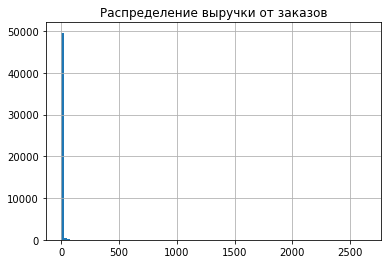

In [16]:
print(orders['revenue'].describe())
orders['revenue'].hist(bins = 100)
plt.title('Распределение выручки от заказов');

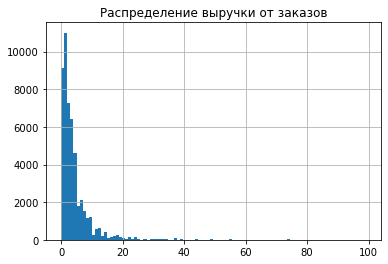

In [17]:
orders.query('revenue < 100')['revenue'].hist(bins = 100)
plt.title('Распределение выручки от заказов');

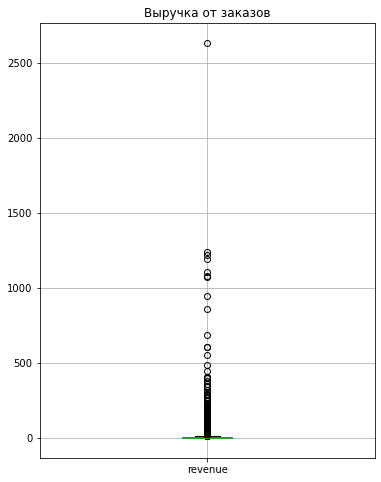

In [18]:
orders.boxplot(column = 'revenue', figsize = (6, 8))
plt.title('Выручка от заказов');

Мы видим, что есть определённый слой заказов, существенно выбивающихся за уровень средних значений. Посмотрим, какие значения выбываются за квонтиль 90%.

In [19]:
print('90% значений выручки находится ниже:',orders['revenue'].quantile(0.9))
rev_90= orders['revenue'].quantile(0.9)
print()
print('Количество заказов с выручкой более', rev_90,':',len(orders.query('revenue>@rev_90')))

90% значений выручки находится ниже: 9.17

Количество заказов с выручкой более 9.17 : 4972


В целом в таблице не выявлено проблем с данными, за исключением некоторых аномально-больших значений.

### Вывод <a index=info2></a>

Мы рассмотрели данные в таблицах **visits**, **orders**, **costs**. 

- Информация о посещении сайта - **visits** содержит **359400** записей в **5** столбцах: uid, device, start_ts, end_ts, source_id
- Информация о совершенных заказах - **orders** содержит **50415** записей в **3** столбцах: uid, buy_ts, revenue
- Информация **costs** содержит **2542** записи в **3** столбцах: source_id, dt, costs

Пропусков в данных не обнаружено. За исключением некоторых аномально больших значений в части выручки данные выглядят корректными.

#### Проведённая обработка

1. Изменены названия столбцов в таблицах **visits** и **orders** (переведены в нижний регистр, добавлены _ вместо пробелов)
2. Приведены к формату Datetime данные в столбцах start_ts, end_ts, dt, buy_ts

Перейдём к подготовке данных для дальнейшего анализа.

### 2. Исследование данных <a index=info3> </a>


#### 2.1. Подготовка данных.  <a index=info4> </a>
Для дальнейшего анализа проведём предварительную подготовку данных. Для формирования когорт выделим месяц первой операции, рассчитаем длительность сессии.

1) Определим дату первого посещения сайта, а также рекламный канал, откуда пользователь пришел в первый раз.

In [20]:
first_visit_date = visits.groupby(['uid'])['start_ts'].min().reset_index()

In [21]:
first_visit_date.head()

,uid,start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [22]:
first_visit_date.columns = ['uid', 'first_visit']
first_visit_date.head()

,uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [23]:
#присоединяем к основной таблице дату и время первого посещения сайта
visits_with_first = visits.merge(first_visit_date , on = 'uid', how = 'left')
visits_with_first.head()

,device,end_ts,source_id,start_ts,uid,first_visit
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27 14:06:00


In [24]:
#определяем, какой источник привлечения был для пользователей первым
first_source = visits_with_first.query('start_ts == first_visit')[['uid', 'source_id']]
first_source.columns = ['uid', 'first_source']
display(first_source.head())

,uid,first_source
0,16879256277535980062,4
1,104060357244891740,2
2,7459035603376831527,5
4,9969694820036681168,3
5,16007536194108375387,5


In [25]:
#добавляем информацию о первом источнике в сборную таблицу
visits_complex = visits_with_first.merge(first_source, on = 'uid', how = 'left')
#определяем месяц, в котором сайт был посещен (для текущего посещения и для первого посещения по пользователю)
visits_complex['visit_month'] = visits_complex['start_ts'].astype('datetime64[M]')
visits_complex['first_visit_month'] = visits_complex['first_visit'].astype('datetime64[M]') 
display(visits_complex.head())

,device,end_ts,source_id,start_ts,uid,first_visit,first_source,visit_month,first_visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,4,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,2,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,5,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00,4,2018-05-01,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27 14:06:00,3,2017-12-01,2017-12-01


In [26]:
#формируем таблицу с первым устройством
first_device = visits_with_first.query('start_ts == first_visit')[['uid', 'device']]
first_device.columns = ['uid', 'first_device']
display(first_device.head())

,uid,first_device
0,16879256277535980062,touch
1,104060357244891740,desktop
2,7459035603376831527,touch
4,9969694820036681168,desktop
5,16007536194108375387,desktop


Мы провели предварительную подготовку таблицы **visits**. 

1. Добавлена информация по первому визиту  
2. Выделен месяц первого визита
3. Выделен первый источник для клиентов
4. Выделено первое устройство для клиентов

2) Подготовим таблицу **orders**. Добавим данные о дате первого заказа по пользователям, 

In [27]:
# выделяем месяц заказа
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]') 
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [28]:
# выделяем дату первого заказа
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()
first_order.columns = ['uid', 'first_order_ts']
# сливаем с основной таблицей
order_complex = orders.merge(first_order, on = 'uid', how = 'left')
# выделяем месяц первого заказа
order_complex['first_order_month'] = order_complex['first_order_ts'].astype('datetime64[M]')
display(order_complex.head())

,buy_ts,revenue,uid,order_month,first_order_ts,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01


Мы провели предварительную обработку таблицы **orders**:

1. Определена дата первого заказа
2. Выделен месяц первого заказа
3. Выделен месяц заказа

#### 2.2.Изучение продуктовых метрик  <a index=info5> </a>

В данном разделе мы рассмотрим следующие показатели:

1) Ежедневное/Еженедельное/Ежемесячное число активных пользователей

2) Среднее количество сессий ежедневно

3) Средняя длительность одной сессии

4) Retention rate


1) Ежедневное/Еженедельное/Ежемесячное число активных пользователей <a index=info6> </a>

Для расчётов воспользуемся сформированной ранее таблицей visits_complex. Добавим в неё значение месяца, года, недели, месяца и отдельно выделим дату.

In [29]:
visits_complex['visit_day'] = visits_complex['start_ts'].dt.date
visits_complex['visit_week'] = visits_complex['start_ts'].dt.week
visits_complex['visit_month'] = visits_complex['start_ts'].dt.month
visits_complex['visit_year'] = visits_complex['start_ts'].dt.year
visits_complex.head()

,device,end_ts,source_id,start_ts,uid,first_visit,first_source,visit_month,first_visit_month,visit_day,visit_week,visit_year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,4,12,2017-12-01,2017-12-20,51,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,2,2,2018-02-01,2018-02-19,8,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,5,7,2017-07-01,2017-07-01,26,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00,4,5,2018-03-01,2018-05-20,20,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27 14:06:00,3,12,2017-12-01,2017-12-27,52,2017


In [30]:
#создаём функцию для расчёта кол-ва уникальных пользователей по выбранным группировкам
def active_users (frame):
    mau = frame.groupby(['visit_year','visit_month']).agg({'uid': 'nunique'}).mean()
    wau = frame.groupby(['visit_year','visit_week']).agg({'uid': 'nunique'}).mean()
    dau = frame.groupby(['visit_day']).agg({'uid': 'nunique'}).mean()
    list = pd.DataFrame({'parameter': [int(dau), int(wau), int(mau)],
                        'name': ['день', 'неделю', 'месяц']})
    for ind in list.index:
        print('Среднее кол-во активных пользователей в', list['name'][ind], ':', list['parameter'][ind])

In [31]:
active_users(visits_complex)

Среднее кол-во активных пользователей в день : 907
Среднее кол-во активных пользователей в неделю : 5716
Среднее кол-во активных пользователей в месяц : 23228


Мы видим, что ежедневно на сайт заходит 907 человек. В неделю - в 6,3 раз больше, в месяц - 25,6 раз больше. 
Рассмотрим распределение этих показателей по устройствам и рекламным каналам.

In [32]:
#создаём функцию для вычисления активных пользователей в нужной разбивке
def au_descr(group, name):
    #формируем выборку по нужной группе
    report_au = (visits_complex.groupby(['device', 'source_id','visit_year',group])
                  .agg({'uid': 'nunique'})
                  .reset_index())
    #формируем аналогичную выборку, но без разбивки по источнику
    report_au1 = (visits_complex.groupby(['device','visit_year',group])
                  .agg({'uid': 'nunique'})
                  .reset_index())
    #на основе предыдущих выборок высчитываем среднее количество активных пользователей за периоды
    report_au_fin = (report_au.pivot_table(index = 'device', columns = 'source_id', values ='uid', aggfunc = 'mean',
                                       margins = False).round().astype('int'))
    report_au_fin1 = (report_au1.pivot_table(index = 'device', values ='uid', aggfunc = 'mean',
                                       margins = False).round().astype('int'))
    print('Распределение кол-ва активных пользователей в {} в зависимости от устройства'.format(name))
    display(report_au_fin1)
    report_au_fin1.plot(kind = 'bar')
    plt.title('Распределение кол-ва активных пользователей в {} в зависимости от устройства'.format(name))
    plt.show();
    print()
    print('Распределение кол-ва активных пользователей в {} в зависимости от канала привлечения'.format(name))
    display(report_au_fin)

Распределение кол-ва активных пользователей в месяц в зависимости от устройства


,uid
device,
desktop,16725
touch,6826


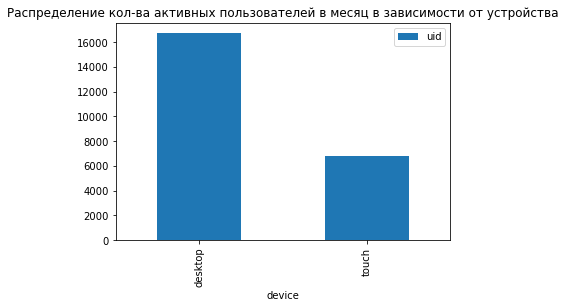


Распределение кол-ва активных пользователей в месяц в зависимости от канала привлечения


source_id,1,2,3,4,5,6,7,9,10
device,,,,,,,,,
desktop,1284,1965,5188,5162,3712,1,2,755,507
touch,548,821,1609,2652,1320,1,1,239,204


In [33]:
au_descr('visit_month', 'месяц')

Распределение кол-ва активных пользователей в неделю в зависимости от устройства


,uid
device,
desktop,4130
touch,1635


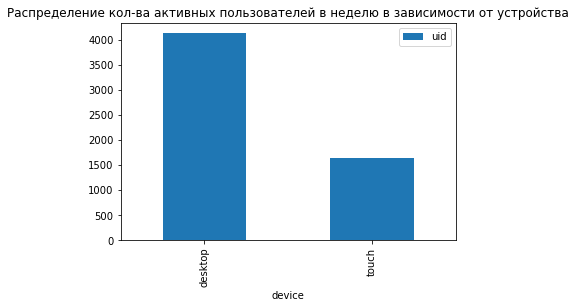


Распределение кол-ва активных пользователей в неделю в зависимости от канала привлечения


source_id,1,2,3,4,5,6,7,9,10
device,,,,,,,,,
desktop,335,522,1203,1218,867,1,1,183,120
touch,131,199,368,618,303,1,1,57,47


In [34]:
au_descr('visit_week', 'неделю')

Распределение кол-ва активных пользователей в день в зависимости от устройства


,uid
device,
desktop,659
touch,253


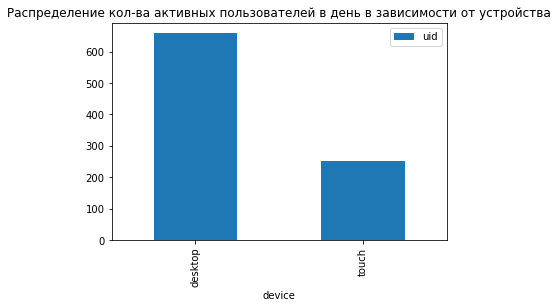


Распределение кол-ва активных пользователей в день в зависимости от канала привлечения


source_id,1,2,3,4,5,6,7,9,10
device,,,,,,,,,
desktop,60,90,179,183,131,1,1,28,19
touch,21,31,54,93,45,1,1,9,7


In [35]:
au_descr('visit_day', 'день')

Мы видим, что бОльшая часть пользователей заходит на сайт с ПК. Наиболее часто клиенты приходят с рекламных каналов 3, 4, 5, а каналы 6 и 7 практически не задействуются.

2) Рассмотрим следующую метрику. Выявим ежедневное количество сессий от одного пользователя. <a index=info7> </a>

Информация по кол-ву сессий на пользователя на дату


,session_date,sessions_n,users,sessions_per_user,session_month
0,2017-06-01,664,605,1.097521,2017-06-01
1,2017-06-02,658,608,1.082237,2017-06-01
2,2017-06-03,477,445,1.071910,2017-06-01
3,2017-06-04,510,476,1.071429,2017-06-01
4,2017-06-05,893,820,1.089024,2017-06-01



Кол-во ежедневных сессий на пользователя по месяцам


,sessions_per_user
session_month,
2017-06-01,1.074
2017-07-01,1.078
2017-08-01,1.067
2017-09-01,1.076
2017-10-01,1.078
2017-11-01,1.093
2017-12-01,1.090
2018-01-01,1.086
2018-02-01,1.090


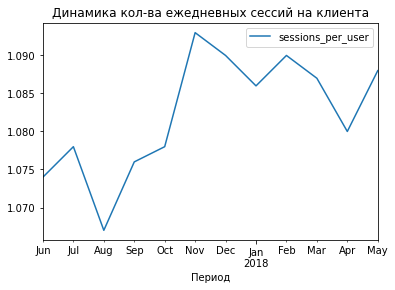

In [36]:
#создаём сводную таблицу, в которой подсчитываем количество сессий и кол-во пользователей
sessions = (visits_complex
              .pivot_table(index = ['visit_day'],values = ['start_ts', 'uid'] , aggfunc =  {'start_ts': 'count',
                                                                                           'uid': 'nunique'})
              .reset_index())

sessions.columns = ['session_date', 'sessions_n', 'users']
sessions['sessions_per_user'] = sessions['sessions_n']/sessions['users']
sessions['session_month'] = sessions['session_date'].astype('datetime64[M]')
print('Информация по кол-ву сессий на пользователя на дату')
display(sessions.head())
#формируем следующую таблицу с группировкой по месяцам и году
sessions_grouped = sessions.pivot_table(index = ['session_month'], values = 'sessions_per_user'
                                        , aggfunc = 'mean').round(3)
print()
print('Кол-во ежедневных сессий на пользователя по месяцам')
display(sessions_grouped)
sessions_grouped.plot()
plt.title('Динамика кол-ва ежедневных сессий на клиента')
plt.xlabel('Период');

Мы видим, что клиенты практически всегда заходят на сайт только 1 раз в день. Следует отметить, что количество посещений возрастает при наступлении зимнего периода и достигает пика в декабре-январе, что может быть отражением сезонности спроса на развлечения.

3) Рассмотрим следующую метрику. Длительность сессии. Рассмотрим, как она отличается в зависимости от типа устройства и канала привлечения. <a index=info8> </a>

In [37]:
#создаём столбец с количеством секунд длительности сессии
visits_complex['session_length'] = (visits_complex['end_ts'] - visits_complex['start_ts']).dt.seconds
visits_complex.head()

,device,end_ts,source_id,start_ts,uid,first_visit,first_source,visit_month,first_visit_month,visit_day,visit_week,visit_year,session_length
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,4,12,2017-12-01,2017-12-20,51,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,2,2,2018-02-01,2018-02-19,8,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,5,7,2017-07-01,2017-07-01,26,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00,4,5,2018-03-01,2018-05-20,20,2018,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27 14:06:00,3,12,2017-12-01,2017-12-27,52,2017,0


count    359402.000000
mean        643.503241
std        1016.332900
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_length, dtype: float64

5% значений длины сессии меньше: 0.0
95% значений длины сессии меньше: 2280.0
Медианное значение длины сессии: 300.0
Кол-во сессий с нулевой длительностью: 35795
Доля сессий с нулевой длительностью: 9.96%


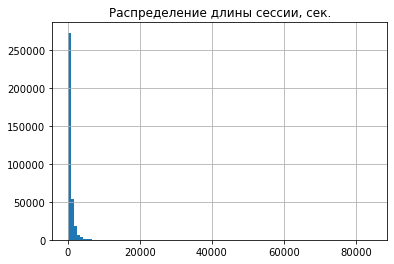

In [38]:
print(visits_complex['session_length'].describe())
print()
print('5% значений длины сессии меньше:', visits_complex['session_length'].quantile(0.05))
print('95% значений длины сессии меньше:', visits_complex['session_length'].quantile(0.95))
print('Медианное значение длины сессии:', visits_complex['session_length'].median())
#подсчитываем количество нулевых сессий
zero_count = visits_complex[visits_complex['session_length']==0]['session_length'].count()
all_len = len(visits_complex['session_length'])
print('Кол-во сессий с нулевой длительностью:', zero_count)
print('Доля сессий с нулевой длительностью: {:.2%}'.format(zero_count/all_len))
visits_complex['session_length'].hist(bins = 100)
plt.title('Распределение длины сессии, сек.')
plt.show();

Мы видим, что средняя продолжительность сессии - 643 секунды - примерно 10,75 минут. В 9,96% случаев сессии были нулевыми. Возможно, что люди не дожидались загрузки, и закрывали сайт.
Медианная длина сессии - 300 секунд - 5 минут.

Рассмотрим, как изменяется длина сессии в зависимости от устройства и канала привлечения.

,session_length
device,
desktop,703.95
touch,479.61


,session_length
source_id,
6,1370.00
1,1039.30
2,844.72
10,662.44
7,606.67
3,573.28
9,572.54
4,559.84
5,526.74


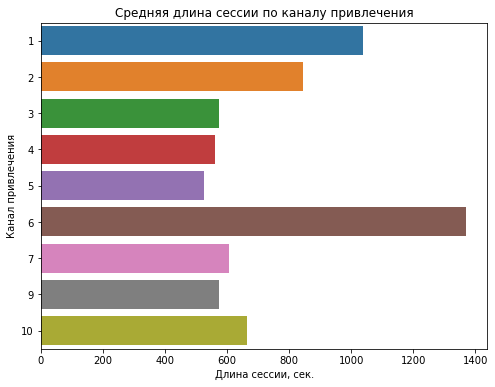

In [39]:
#Сводим таблицу по устройству со средней длительностью сессии
session_length_dev = visits_complex.pivot_table(index = 'device' ,values = 'session_length', aggfunc = 'mean').round(2)
display(session_length_dev)
#сводим таблицу по источникам привлечения со средней длительностью сессии
session_length_source = visits_complex.pivot_table(index = 'source_id' ,values = 'session_length', aggfunc = 'mean').round(2)
session_length_source = session_length_source.sort_values('session_length',ascending = False)
display(session_length_source)
session_length_source = session_length_source.reset_index()

fig, ax = plt.subplots(figsize=(8, 6))
plot = sns.barplot(data = session_length_source, x = 'session_length', y = 'source_id', orient = 'h', ax = ax)
plt.title('Средняя длина сессии по каналу привлечения')
plt.xlabel('Длина сессии, сек.')
plt.ylabel('Канал привлечения');

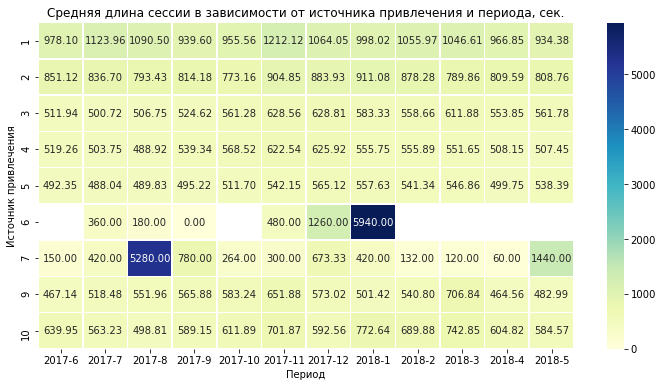

In [40]:
#формируем сводную таблицу по источникам со средней длительностью сессии 
session_len_sour_month = visits_complex.pivot_table(index = 'source_id' 
                                                    , columns = ['visit_year', 'visit_month']
                                                    ,values = 'session_length', aggfunc = 'mean').round(2)
f, ax = plt.subplots(figsize=(12, 6))
#строим тепловую карту на основе ранее созданной сводной
sns.heatmap(session_len_sour_month, annot=True, linewidths=.5, ax=ax, fmt = '.2f', cmap = "YlGnBu");
plt.title('Средняя длина сессии в зависимости от источника привлечения и периода, сек.')
plt.xlabel('Период')
plt.ylabel('Источник привлечения');
#sns.color_palette("mako", as_cmap=True)

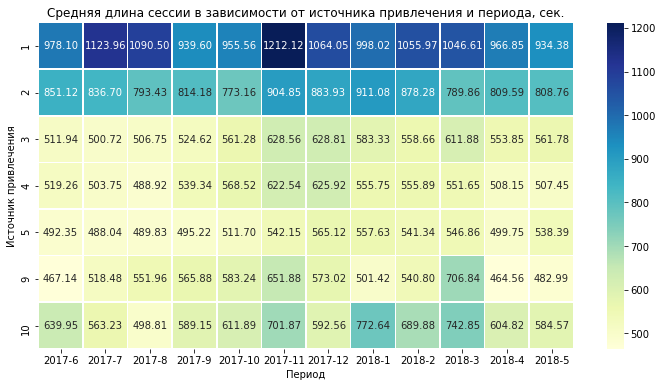

In [41]:
#Строим сводную и тепловую карту, исключив из выборки источники 6 и 7
session_len_sour_month = (visits_complex
                          .query('source_id not in (6,7)')
                          .pivot_table(index = 'source_id' 
                                                    , columns = ['visit_year', 'visit_month']
                                                    ,values = 'session_length', aggfunc = 'mean').round(2))
f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(session_len_sour_month, annot=True, linewidths=.5, ax=ax, fmt = '.2f', cmap = "YlGnBu");
plt.title('Средняя длина сессии в зависимости от источника привлечения и периода, сек.')
plt.xlabel('Период')
plt.ylabel('Источник привлечения');
#sns.color_palette("mako", as_cmap=True)

Мы видим, что пользователи проводят больше времени на сайте, если заходят с ПК (**703** секунды против **479**). 
Наибольшей длительностью отличаются сессии пользователей, пришедших из **1, 2** и **10** источников. Длительность по каналам 6 и 7 считаем возможным не учитывать при анализе поведения пользователей, так как привлечение клиентов по ним практически не производится и является, с большой вероятностью, случайным.
В среднем по всем источникам пользователи проводят на сайте около 10 минут, по лидирующему по длительности - источнику 1 - **17,31** минут.
Рассмотрим, как изменяется длительность сессии в зависимости от периода.

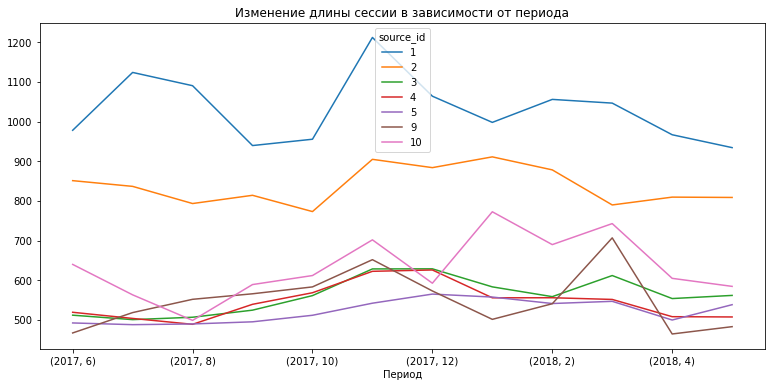

In [42]:
#строим графиги изменения длительности сессии в зависимости от периода и источника привлечения
session_len_plot = (visits_complex
                    .query('source_id not in (6,7)')
                    .pivot_table(index = ['visit_year', 'visit_month']
                                                    , columns = 'source_id'
                                                    ,values = 'session_length', aggfunc = 'mean')
                    .round(2)
                    .plot(figsize = (13, 6)))
plt.title('Изменение длины сессии в зависимости от периода')
plt.xlabel('Период');

Сезонное изменение длительности сессий показывает несколько пиков:

1. Ноябрь - Декабрь (может быть связано с ухудшением погоды и более частым посещением мероприятий, а также поиском предложений к предновогоднему и новогоднему периоду)
2. Март (может быть связано с праздником 8 марта и выбором мероприятий для посещения со своей "второй половинкой")

4) Исследование Retention rate. <a index=info9> </a>

Рассмотрим, насколько часто возвращаются клиенты. Рассмотрим 2 варианта расчета данного показателя:
1) по покупкам
2) по посещению

4.1.

In [43]:
order_complex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   buy_ts             50415 non-null  datetime64[ns]
 1   revenue            50415 non-null  float64       
 2   uid                50415 non-null  uint64        
 3   order_month        50415 non-null  datetime64[ns]
 4   first_order_ts     50415 non-null  datetime64[ns]
 5   first_order_month  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), uint64(1)
memory usage: 2.7 MB


In [44]:
#формируем столбец lifetime - число периодов, начиная с первой покупки
order_complex['lifetime'] = (order_complex['order_month'] - order_complex['first_order_month'])/np.timedelta64(1, 'M')
order_complex['lifetime'] = order_complex['lifetime'].round().astype('int64')
order_complex.head()

,buy_ts,revenue,uid,order_month,first_order_ts,first_order_month,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,0


In [45]:
order_complex['lifetime'].value_counts()

0     41588
1      2404
2      1519
3      1221
4       945
5       738
6       682
7       483
8       377
9       223
10      149
11       86
Name: lifetime, dtype: int64

In [46]:
#формируем когорты - группы клиентов по дате первой покупки
cohorts = order_complex.groupby(['first_order_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()
users_zero = cohorts[cohorts['lifetime'] == 0][['first_order_month', 'uid']]
display(cohorts.head())
display(users_zero.head())

,first_order_month,lifetime,uid
0,2017-06-01,0,2023
1,2017-06-01,1,61
2,2017-06-01,2,50
3,2017-06-01,3,54
4,2017-06-01,4,88


,first_order_month,uid
0,2017-06-01,2023
12,2017-07-01,1923
23,2017-08-01,1370
33,2017-09-01,2581
42,2017-10-01,4340


In [47]:
#создаём вспомогательный фрейм с количеством клиентов на нулевой период
users_zero = users_zero.rename(columns = {'uid': 'cohort_users'})
# добавляем количество к основной таблице
cohorts = cohorts.merge(users_zero, on = 'first_order_month', how = 'left')
display(cohorts.head())

,first_order_month,lifetime,uid,cohort_users
0,2017-06-01,0,2023,2023
1,2017-06-01,1,61,2023
2,2017-06-01,2,50,2023
3,2017-06-01,3,54,2023
4,2017-06-01,4,88,2023


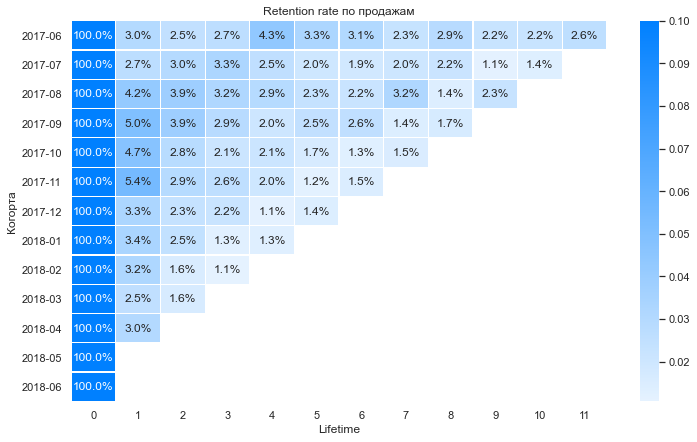

In [48]:
#определяем retention rate как кол-во пользователей/стартовое количество пользователей
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts['first_order_month'] = cohorts['first_order_month'].dt.strftime('%Y-%m')
#строим сводную таблицу с retention rate
retention_rate = cohorts.pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'retention', aggfunc = 'sum')
#retention_rate_map = retention_rate[retention_rate]
sns.set(style = 'white')
plt.figure(figsize = (12, 7))
plt.title('Retention rate по продажам')
#задаём цвет для тепловой карты и формируем карту
cmap = sns.light_palette("#0080ff", as_cmap=True)
sns.heatmap(retention_rate, annot = True, fmt ='.1%', cmap = cmap, linewidth = 0.2, linecolor = 'white', vmax = 0.1)
plt.xlabel('Lifetime')
plt.ylabel('Когорта');

Мы видим, что повторно возвращается, в среднем, не более трёх процентов покупателей. В долгосрочной перспективе мы видим, что retention rate остаётся на приблизительно на одном уровне. Это может говорить о следущюей поведенческой модели:

- 97% клиентов не возвращается после первой покупки (т.е. покупка была разовой)
- оставшиеся клиенты формируют устойчивый спрос
- когорты из более поздних периодов быстрее теряют клиентов

4.2) Рассмотрим, насколько часто возвращаются пользователи на сайт после первого просмотра

In [49]:
visits_complex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359402 entries, 0 to 359401
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   device             359402 non-null  object        
 1   end_ts             359402 non-null  datetime64[ns]
 2   source_id          359402 non-null  int64         
 3   start_ts           359402 non-null  datetime64[ns]
 4   uid                359402 non-null  uint64        
 5   first_visit        359402 non-null  datetime64[ns]
 6   first_source       359402 non-null  int64         
 7   visit_month        359402 non-null  int64         
 8   first_visit_month  359402 non-null  datetime64[ns]
 9   visit_day          359402 non-null  object        
 10  visit_week         359402 non-null  int64         
 11  visit_year         359402 non-null  int64         
 12  session_length     359402 non-null  int64         
dtypes: datetime64[ns](4), int64(6), object(2), u

In [50]:
#формируем lifetime для посещений сайта
visits_complex['visit_month_dt'] = visits_complex['start_ts'].astype('datetime64[M]')
visits_complex['lifetime'] = (visits_complex['visit_month_dt'] - visits_complex['first_visit_month'])/np.timedelta64(1,'M')
visits_complex['lifetime'] = visits_complex['lifetime'].round().astype('int64')
#формируем когорты по первому визиту и выбираем количество пользователей на нулевой период
visits_cohorts = visits_complex.groupby(['first_visit_month', 'lifetime']).agg({'uid': 'nunique'}).reset_index()
first_visitors = visits_cohorts[visits_cohorts['lifetime'] == 0][['first_visit_month', 'uid']]
first_visitors = first_visitors.rename(columns = {'uid': 'visitors_zero'})
visits_cohorts = visits_cohorts.merge(first_visitors, on = 'first_visit_month', how = 'left')
visits_cohorts.head()

,first_visit_month,lifetime,uid,visitors_zero
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


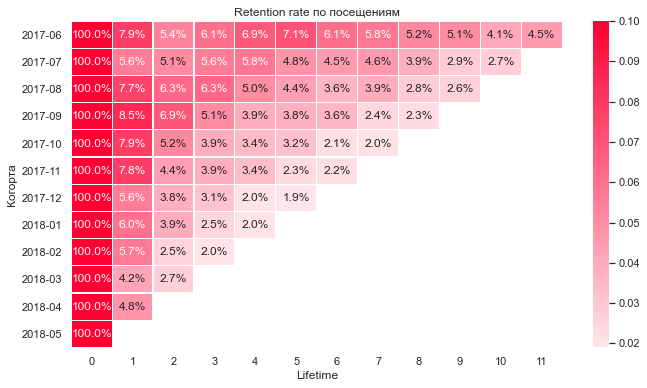

In [51]:
#определяем retention rate
visits_cohorts['retention'] = visits_cohorts['uid']/visits_cohorts['visitors_zero']
visits_cohorts['first_visit_month'] = visits_cohorts['first_visit_month'].dt.strftime('%Y-%m')
visits_retention = visits_cohorts.pivot_table(index = 'first_visit_month', columns = 'lifetime', values = 'retention', aggfunc = 'sum')
plt.figure(figsize = (11, 6))
plt.title('Retention rate по посещениям')
cmap1 = sns.light_palette("#ff0033", as_cmap=True) #задаём цвет для тепловой карты
sns.heatmap(visits_retention, annot = True, fmt = '.1%', cmap = cmap1, linewidth = 0.2, linecolor = 'white', vmax = 0.1)
plt.xlabel('Lifetime')
plt.ylabel('Когорта');

Мы видим, что когортах более позднего периода количество повторных посещений уже со 2 периода снижается быстрее, чем среди пользователей, заходивших на сайт в 2017 году.

Ранее retention rate снижался до уровня в 2,5% после 6-7 периодов, то в более поздних когортах - 3-4 период. Т.е. новые пользователи имеют меньше тенденцию к возвращению на сайт. 

В целом, можно сказать, что заметны тенденции, аналогичные тем, что наблюдались в продажах. Пользователи, подключившиеся летом 2017г. сохраняют бОльшую лояльность. Новые клиенты, в свою очередь, реже совершают повторные покупки и реже заходят на сайт повторно.


#### Итоги по продуктовым метрикам <a index=info10> </a>

При анализе метрик мы получили следующие результаты:

- Среднее кол-во активных пользователей в день : **907**
- Среднее кол-во активных пользователей в неделю : **5716**
- Среднее кол-во активных пользователей в месяц : **23228**
- Клиенты примерно в 2,5 раза чаще заходят на сайт с ПК, чем с мобильных платформ
- Основные каналы привлечения - **3,4,5**
- В среднем, клиент проводит на сайте **10,75** минут (медианное значение - 5 минут)
- Дольше всего задерживаются на сайте клиенты, пришедшие от источников **1,2 и 10**.
- Клиенты, пришедшие летом 2017 года, были более лояльны, чем новые клиенты последних периодов. Вероятность совершения повторной покупки/повторного посещения сайта снижается в более поздних когортах.

#### 2.3. Изучение метрик по продажам <a index=info11> </a>

В рамках данного подраздела мы исследуем метрики по продажам:

1) Разница во времени между первым посещением и первой покупкой

2) Среднее количество покупок за период

3) Средний чек

**1) Рассмотрим, за какое время клиент в среднем принимает решение об осуществлении покупки** <a index=info12> </a>

Сформируем комплексную таблицу из трёх таблиц с данными по первому посещению, первому источнику и первому заказу

In [52]:
print(first_visit_date.info())
print()
print(first_source.info())
print()
print(first_order.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228169 entries, 0 to 228168
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uid          228169 non-null  uint64        
 1   first_visit  228169 non-null  datetime64[ns]
dtypes: datetime64[ns](1), uint64(1)
memory usage: 3.5 MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228170 entries, 0 to 359399
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   uid           228170 non-null  uint64
 1   first_source  228170 non-null  int64 
dtypes: int64(1), uint64(1)
memory usage: 5.2 MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36523 entries, 0 to 36522
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   uid             36523 non-null  uint64        
 1   first_order_ts  3652

In [53]:
#Сливаем таблицы по первой покупке и первому визиту так, чтобы uid присутствовал в обеих таблицах
first_purchase = first_visit_date.merge(first_order, on = 'uid', how = 'inner')
first_purchase = first_purchase.merge(first_source, on = 'uid', how = 'left')
first_purchase = first_purchase.merge(first_device, on = 'uid', how = 'left')
first_purchase.head()

,uid,first_visit,first_order_ts,first_source,first_device
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,2,desktop
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,10,touch
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,3,desktop
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,5,desktop
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,5,desktop


In [54]:
#добавим столбец с разницей между покупкой и посещением
first_purchase['purchase_lag'] = (first_purchase['first_order_ts'] - first_purchase['first_visit']).dt.seconds
first_purchase.head()

,uid,first_visit,first_order_ts,first_source,first_device,purchase_lag
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,2,desktop,82920
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,10,touch,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,3,desktop,4740
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,5,desktop,71040
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,5,desktop,0


count    36523.000000
mean     14949.881445
std      25784.567076
min          0.000000
25%        240.000000
50%        960.000000
75%      15120.000000
max      86340.000000
Name: purchase_lag, dtype: float64

Количество нулевых значений: 2467
Доля нулевых значений: 6.75%


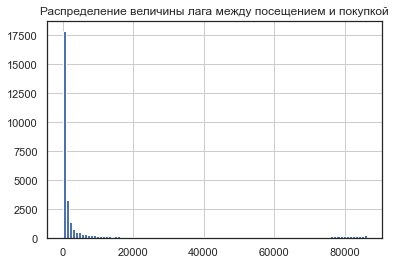

In [55]:
print(first_purchase['purchase_lag'].describe())
print()
print('Количество нулевых значений:', first_purchase[first_purchase['purchase_lag'] == 0]['purchase_lag'].count())
print('Доля нулевых значений: {:.2%}'.format(first_purchase[first_purchase['purchase_lag'] == 0]['purchase_lag'].count()/len(first_purchase['purchase_lag'])))
first_purchase['purchase_lag'].hist(bins = 100)
plt.title('Распределение величины лага между посещением и покупкой')
plt.show();

В **6,75%** случаев покупка совершалась в тот же момент, что и переход на сайт. Возможно, что произошел переход с иного сайта сразу в форму покупки.

Средний лаг между первым посещением и первой покупкой составляет **252** минуты.

Если рассматривать медиану, то лаг составляет 960 секунд - **16** минут.

Попробуем рассмотреть данный показатель, отрезав выбросы:

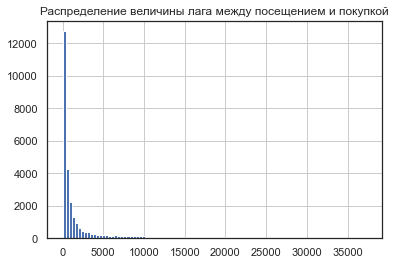

count    30063.000000
mean      3731.216445
std       7355.802268
min          0.000000
25%        180.000000
50%        540.000000
75%       2580.000000
max      37380.000000
Name: purchase_lag, dtype: float64


In [56]:
q1 = first_purchase['purchase_lag'].quantile(0.25)
q3 =  first_purchase['purchase_lag'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + 1.5*iqr
lower_limit = q1 - 1.5*iqr
#ограничиваем выборку пределами в 
result = first_purchase.query('@lower_limit<purchase_lag<@upper_limit')['purchase_lag']
result.hist(bins = 100)
plt.title('Распределение величины лага между посещением и покупкой')
plt.show();
print(result.describe())

Если убрать выбросы более q3+iqr* 1.5 , то средний лаг составит - **62 минуты**.

Медианная длительность - **9 минут**.

Принимая во внимание среднюю длину сессии, можно сказать, что в среднем за одну сессию клиент не успевает совершить покупку (**10,75 минут** против **252 минут**). Если рассматривать медианную длину сессии, то также выбор редко бывает сделан (**5 минут** против **16 минут**).

Рассмотрим различие среднего лага по источникам привлечения и устройствам:

,purchase_lag
first_source,
9,25668.0
2,16694.0
3,15520.0
4,15084.0
10,12813.0
5,12769.0
1,12479.0
7,3120.0


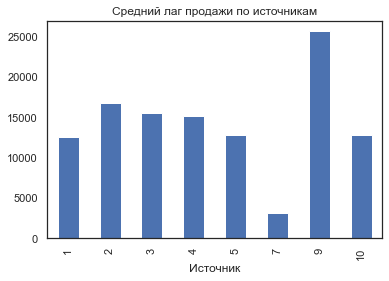

In [57]:
res_lag = first_purchase.pivot_table(index = 'first_source', values = 'purchase_lag', aggfunc = 'mean').round()
display(res_lag.sort_values('purchase_lag', ascending = False))
res_lag['purchase_lag'].plot(kind='bar')
plt.title('Средний лаг продажи по источникам')
plt.xlabel('Источник')
plt.show();

,purchase_lag
first_device,
touch,18699.0
desktop,14011.0


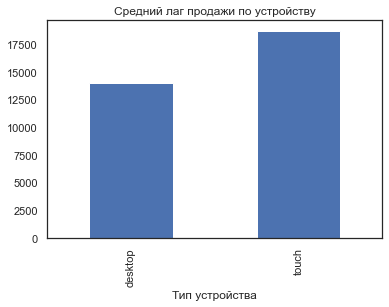

In [58]:
device_lag = first_purchase.pivot_table(index = 'first_device', values = 'purchase_lag', aggfunc = 'mean').round()
display(device_lag.sort_values('purchase_lag', ascending = False))
device_lag['purchase_lag'].plot(kind='bar')
plt.title('Средний лаг продажи по устройству')
plt.xlabel('Тип устройства')
plt.show();

Мы видим, что по всем источника лаг довольно большой и превышает средние длины сессий. Таким образом, мы видим, что клиенты не совершают покупку при первом заходе на сайт.

Лаг на ПК также ниже, чем на переносных устройствах - разница составляет **78** минут.

2) Среднемесячное количество покупок. <a index=info13> </a>

Исследуем, какое количество покупок производится клиентом в среднем за месяц.

In [59]:
order_complex.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   buy_ts             50415 non-null  datetime64[ns]
 1   revenue            50415 non-null  float64       
 2   uid                50415 non-null  uint64        
 3   order_month        50415 non-null  datetime64[ns]
 4   first_order_ts     50415 non-null  datetime64[ns]
 5   first_order_month  50415 non-null  datetime64[ns]
 6   lifetime           50415 non-null  int64         
dtypes: datetime64[ns](4), float64(1), int64(1), uint64(1)
memory usage: 3.1 MB


,order_month,purchase_n,users_n
0,2017-06,2354,2023
1,2017-07,2363,1984
2,2017-08,1807,1472
3,2017-09,3387,2750
4,2017-10,5679,4675
5,2017-11,5659,4547
6,2017-12,6218,4942
7,2018-01,4721,3898
8,2018-02,5281,4258
9,2018-03,5326,4181


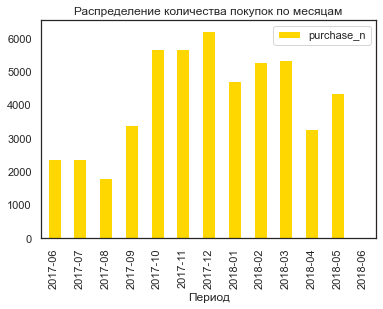

In [60]:
avg_purchases = order_complex.pivot_table(index = 'order_month', values = ['buy_ts', 'uid']
                                          , aggfunc = {'buy_ts': 'count', 'uid': 'nunique'}).reset_index()
avg_purchases['order_month'] = avg_purchases['order_month'].dt.strftime('%Y-%m')
avg_purchases.columns = ['order_month', 'purchase_n', 'users_n']
display(avg_purchases)
avg_purchases.plot(y = 'purchase_n', x = 'order_month', kind = 'bar', color = ['gold'])
#avg_purchases['buy_ts'].plot(color = ['gray'])
plt.title('Распределение количества покупок по месяцам')
plt.xlabel('Период')
plt.show();

Мы видим, что абсолютное число покупок возрастает в зимний период и постепенно снижается ближе к летним месяцам. Также относительное затишье наблюдается в **январе**, хотя на этот период приходятся новогодние праздники. Возможно, что билеты на праздничные недели массово приобретаются в **декабре**, и поэтому в сам период величина спроса снижается.

Определим среднее количество покупок на клиента в месяц.

,order_month,purchase_n,users_n,avg_per_user
0,2017-06,2354,2023,1.16
1,2017-07,2363,1984,1.19
2,2017-08,1807,1472,1.23
3,2017-09,3387,2750,1.23
4,2017-10,5679,4675,1.21
5,2017-11,5659,4547,1.24
6,2017-12,6218,4942,1.26
7,2018-01,4721,3898,1.21
8,2018-02,5281,4258,1.24
9,2018-03,5326,4181,1.27



Среднее кол-во покупок на клиента в месяц: 1.20


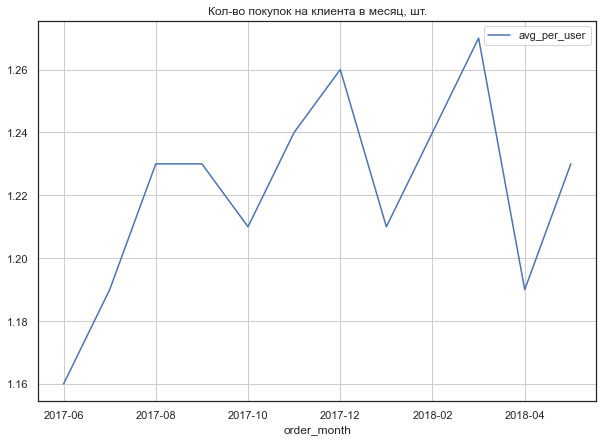

In [61]:
avg_purchases['avg_per_user'] = (avg_purchases['purchase_n']/avg_purchases['users_n']).round(2)
display(avg_purchases)
print()
print('Среднее кол-во покупок на клиента в месяц: {:.2f}'.format(avg_purchases['avg_per_user'].mean()))
avg_purchases[avg_purchases['order_month'] != '2018-06'].plot(x = 'order_month', y = 'avg_per_user', grid = True, figsize = (10,7))
plt.title('Кол-во покупок на клиента в месяц, шт.')
plt.show();

В среднем клиент делает **1,2** покупки в месяц. Наибольшее кол-во покупок на клиента приходится на декабрь и март - предновогодний период и период, близкий к 8 марта.

Проверим, изменяется ли параметр в зависимости от источника привлечения. Добавим в таблицу **order_complex** информацию о первом канале привлечения.

In [62]:
order_complex = order_complex.merge(first_source, on = 'uid', how = 'left')
order_complex = order_complex.merge(first_device, on = 'uid', how = 'left')
order_complex.head()

,buy_ts,revenue,uid,order_month,first_order_ts,first_order_month,lifetime,first_source,first_device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,0,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,0,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,0,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,0,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,0,3,desktop


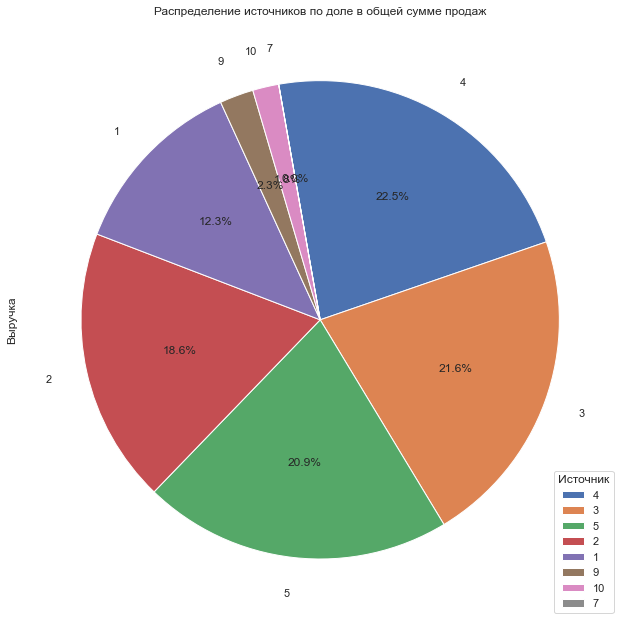

In [63]:
total_revenue = (order_complex.pivot_table(index = 'first_source', values = 'revenue', aggfunc = 'sum')
                 .sort_values('revenue', ascending = False))
            

total_revenue.plot(
    kind = 'pie', y = 'revenue', figsize = (11,11)
    , startangle=100, autopct='%1.1f%%', counterclock = False, labeldistance = 1.15)
plt.ylabel('Выручка')
plt.legend(title = 'Источник', loc = 4)
plt.title('Распределение источников по доле в общей сумме продаж')
plt.show()

Наибольшая доля совокупной выручки приходит с каналов 4 и 3 (с этих же каналов пришло большее число клиентов). Каналы 9, 10 и 7 практически не вносят вклад в совокупный доход.

In [64]:
#загоняем процедуру формирования сводных таблиц и тепловой карты для анализа среднего кол-ва покупок на пользователя
def avg_purch_analysis(col_name, y_name):
    avg_purchases_source = order_complex.pivot_table(index = [col_name, 'order_month'], values = ['buy_ts', 'uid'], aggfunc = {'buy_ts': 'count',
                                                                                                                               'uid': 'nunique'}).reset_index()
                                                                                                                                         
    avg_purchases_source['order_month'] = avg_purchases_source['order_month'].dt.strftime('%Y-%m')
    avg_purchases_source.columns = [col_name,'order_month', 'purchase_n', 'users_n']
    avg_purchases_source['avg_purch'] = (avg_purchases_source['purchase_n']/avg_purchases_source['users_n']).round(2)
    display(avg_purchases_source.head())
    purchases_report = avg_purchases_source.pivot_table(index = col_name, columns = 'order_month', values = 'avg_purch',
                                                   aggfunc = 'mean', dropna = True)

    plt.figure(figsize = (10, 6))
    sns.heatmap(purchases_report, annot=True, linewidths=0.2, linecolor = 'white', fmt = '.2f', cmap = "YlGnBu")
    plt.title('Количество покупок на клиента в месяц')
    plt.xlabel('Период')
    plt.ylabel(y_name);

,first_device,order_month,purchase_n,users_n,avg_purch
0,desktop,2017-06,1994,1702,1.17
1,desktop,2017-07,1889,1577,1.20
2,desktop,2017-08,1494,1200,1.25
3,desktop,2017-09,2761,2208,1.25
4,desktop,2017-10,4624,3815,1.21


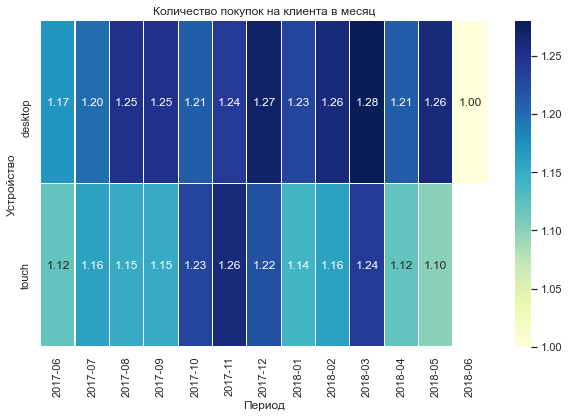

In [65]:
#сформируем свод по среднему количеству покупок в разрезе по устройствам
avg_purch_analysis('first_device', 'Устройство')

Мы видим, что между устройствами нет существенной разницы в количестве покупок на клиента, хотя количество покупок на ПК в среднем немного больше (примерно на **0.1**).

,first_source,order_month,purchase_n,users_n,avg_purch
0,1,2017-06,268,190,1.41
1,1,2017-07,261,176,1.48
2,1,2017-08,243,128,1.90
3,1,2017-09,449,255,1.76
4,1,2017-10,587,376,1.56


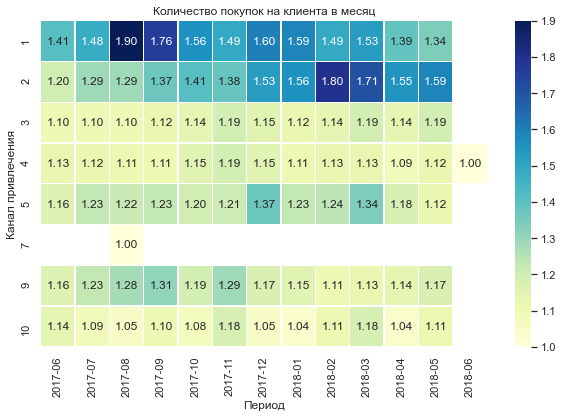

In [66]:
#формируем свод по источникам привлечения
avg_purch_analysis('first_source', 'Канал привлечения')

Мы видим, что по источникам **1** и **2** количество покупок на клиента в нескольких периодах близко к **1,5** (с максимумом в 1.9). Ранее мы выявили. что по источникам 1 и 2 наблюдается наибольшая длина сессий. Похоже, что клиенты с этих источников дольше задерживаются на сайте, чтобы сделать больше покупок.

Переходим к рассмотрению следующей метрики.

3) Исследуем среднюю выручку от покупки. <a index=info14> </a>

Изучим общее значение и распределение по источникам и устройствам.

Средняя выручка на одну продажу: 4.84


,order_month,avg_check
0,2017-06,4.06
1,2017-07,5.31
2,2017-08,4.85
3,2017-09,5.42
4,2017-10,4.93
5,2017-11,4.78
6,2017-12,5.85
7,2018-01,4.11
8,2018-02,4.84
9,2018-03,5.41


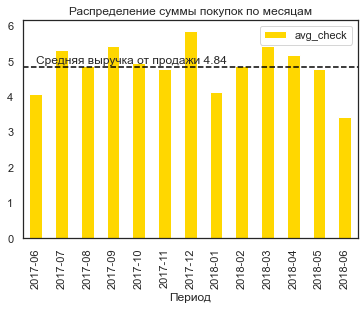

In [67]:
avg_sum = order_complex.pivot_table(index = 'order_month', values = ['revenue']
                                          , aggfunc = 'mean').reset_index()
avg_sum['order_month'] = avg_sum['order_month'].dt.strftime('%Y-%m')
avg_sum.columns = ['order_month', 'avg_check']
avg_sum['avg_check'] = avg_sum['avg_check'].round(2)
print('Средняя выручка на одну продажу: {:.2f}'.format(avg_sum['avg_check'].mean()))
display(avg_sum)
avg_sum.plot(y = 'avg_check', x = 'order_month', kind = 'bar', color = ['gold'])
plt.axhline(avg_sum['avg_check'].mean(),linestyle = 'dashed', color = 'black')
plt.text(0, avg_sum['avg_check'].mean()*1.02, 'Средняя выручка от продажи {:.2f}'.format(avg_sum['avg_check'].mean()))
plt.title('Распределение суммы покупок по месяцам')
plt.xlabel('Период')
plt.show();

В лидерах по среднему чеку - **декабрь, март и июль**. Мы также видим уже ранее замеченное снижение покупательной спопобности в **январе** и **июне**.

В целом, в большинстве периодов средняя выручка от продажи не очень сильно отклоняется от среднего **4.84**.

Рассмотрим распределение среднего чека в зависимости от устройства и канала привлечения.

In [68]:
#задаём функцию для создания сводной таблицы и тепловой карты
def avg_sum_analysis(col_name, y_name):
    avg_purchases_source = order_complex.pivot_table(index = [col_name, 'order_month'], values = ['revenue'], aggfunc = 'mean').reset_index()
                                                                                                                                         
    avg_purchases_source['order_month'] = avg_purchases_source['order_month'].dt.strftime('%Y-%m')
    avg_purchases_source.columns = [col_name,'order_month', 'avg_revenue']
    display(avg_purchases_source.head())
    purchases_report = avg_purchases_source.pivot_table(index = col_name, columns = 'order_month', values = 'avg_revenue',
                                                   aggfunc = 'mean', dropna = True)
    display(avg_purchases_source.groupby(col_name)['avg_revenue'].mean())
    plt.figure(figsize = (10, 6))
    sns.heatmap(purchases_report, annot=True, linewidths=0.2, linecolor = 'white', fmt = '.2f', cmap = "YlGnBu")
    plt.title('Средняя выручка от одного заказа')
    plt.xlabel('Период')
    plt.ylabel(y_name);

,first_device,order_month,avg_revenue
0,desktop,2017-06,4.173205
1,desktop,2017-07,5.427099
2,desktop,2017-08,4.858494
3,desktop,2017-09,5.661489
4,desktop,2017-10,4.994539


first_device
desktop    4.976402
touch      4.318152
Name: avg_revenue, dtype: float64

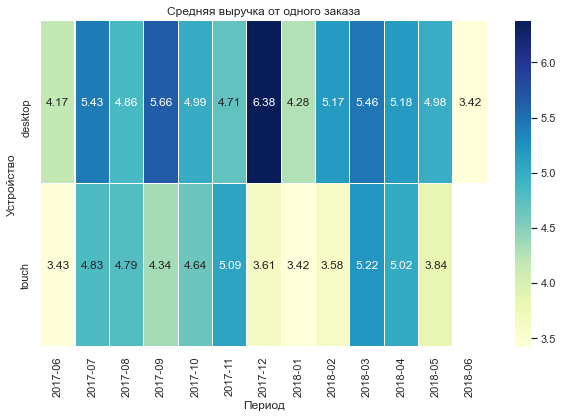

In [69]:
avg_sum_analysis('first_device', 'Устройство')

В среднем средний чек пользователей с ПК больше на **0.66** у.е., чем средний чек пользователей с мобильных устройств. Рекордные значения по величине покупки приходятся на декабрь и ПК (при этом на мобильных устройствах это один из наименее прибыльных периодов). 

Рассмотрим средний чек по каналам привлечения.

,first_source,order_month,avg_revenue
0,1,2017-06,5.144403
1,1,2017-07,6.060077
2,1,2017-08,5.932058
3,1,2017-09,6.841002
4,1,2017-10,6.170051


first_source
1     6.000248
2     6.951092
3     4.242611
4     4.373632
5     5.249257
7     1.220000
9     3.542812
10    2.951389
Name: avg_revenue, dtype: float64

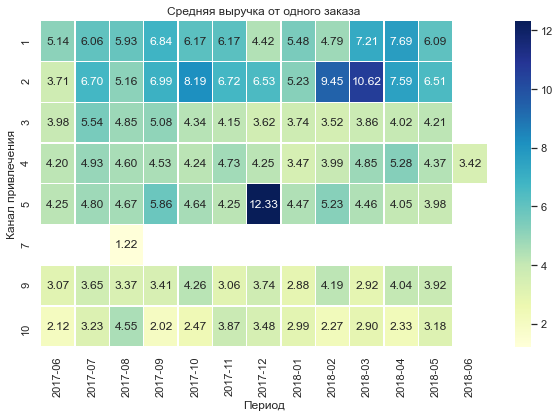

In [70]:
avg_sum_analysis('first_source', 'Канал привлечения')

Наибольший средний чек мы получаем от источников **1** и **2** (6.0 и 6.95). Высокое среднеее значение по источнику **5** (5.24) объясняется наличием большой суммы продаж в декабре. 

####  Итоги метрик по продажам <a index=info15> </a>

При анализе метрик были выявлены следующие характеристики:

- Средний лаг между первым посещением и первой покупкой составляет **252** минуты. (без выбросов - **62** минуты)
- медианный лаг составляет 960 секунд - **16** минут. (без выбросов - **9** минут)
- лаг между покупкой и первым посещением на мобильных устройствах больше на 78 минут, чем на ПК
- лаг показывает. что клиент чаще всего **не** совершает покупку в первое посещение
- в среднем клиент совершает 1.2 покупки в месяц
- количество покупок на клиента с мобильных устройств и ПК практически не отличается
- больше всего покупок на клиента совершают люди, привлечённые от источников **1, 2 и 5**
- наибольшую долю в совокупной выручке занимают клиенты с каналов **3 и 4** (около 22% каждый), однако с каналов 2 и 5 приходит такой же доход (около 20%)
- Средняя выручка на одну продажу: **4.84**
- наиболее дорогие покупки клиенты совершают в **декабре, марте и июле**. Наименее дорогие в **январь, июне**.
- средний чек клиентов с ПК больше на **0.66** ед., чем на мобильных устройствах
- более дорогие покупки совершают клиенты с каналами привлечения **1, 2 и 5**

#### 2.4. Финансовые метрики <a index=info16> </a>

Рассмотрим показатели, характеризующие эффективность бизнеса.

1) LTV

2) Затраты на клиента (CAC)

3) ROI

1) Рассмотрим LTV - прибыль, которую приносит клиент за время жизни <a index=info17> </a>

,source_users
first_source,
1,2899
2,3506
3,10473
4,10296
5,6931
7,1
9,1088
10,1329


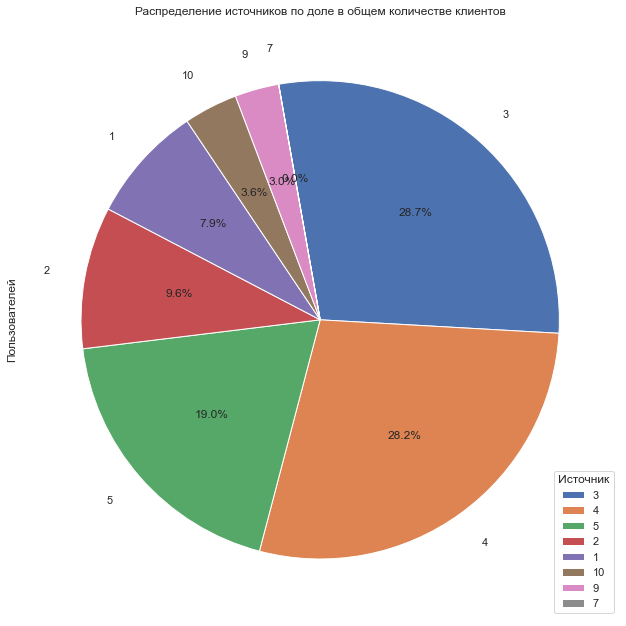

In [71]:
#сфомируем когорты по источникам привлечения и посчитаем их величину
cohort_sizes_source = order_complex.groupby('first_source').agg({'uid': 'nunique'})
#cohort_sizes_source = cohort_sizes_source.drop(columns = 'first_source')
cohort_sizes_source.columns = ['source_users']
display(cohort_sizes_source)
#строим круговую диаграмму, показывающую долю пользователей по источникам
(cohort_sizes_source.sort_values('source_users', ascending = False)
 .plot(
    kind = 'pie', y = 'source_users', figsize = (11,11)
    , startangle=100, autopct='%1.1f%%', counterclock = False, labeldistance = 1.15))
plt.ylabel('Пользователей')
plt.legend(title = 'Источник', loc = 4)
plt.title('Распределение источников по доле в общем количестве клиентов')
plt.show()

In [72]:
#cohort_sizes_period = users_zero.copy().reset_index()
#cohort_sizes_period = cohort_sizes_period.drop(columns = 'index')
#формируем когорты по дате первой покупки в группировке по месмяцам
cohort_sizes_period = order_complex.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes_period['first_order_month'] = cohort_sizes_period['first_order_month'].dt.strftime('%Y-%m-%d')
display(cohort_sizes_period)
print(cohort_sizes_period.info())

,first_order_month,uid
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   first_order_month  13 non-null     object
 1   uid                13 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 336.0+ bytes
None


In [73]:
#строим подготовительную таблицу ltv для когорт по источнику привлечения
ltv_source = (order_complex.copy().pivot_table(index = 'first_source', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0))
display(ltv_source)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_source,,,,,,,,,,,,
1,18103.37,2671.98,2282.85,2110.42,1172.91,733.03,746.61,1061.59,951.02,561.96,377.39,317.42
2,23177.60,4971.97,5632.24,5655.43,2457.37,1863.43,1283.84,691.52,463.03,230.44,394.92,101.82
3,47009.04,2825.65,1520.43,1033.09,744.13,497.94,282.90,260.29,195.57,75.26,46.41,20.53
4,46901.20,1923.59,984.77,1355.08,1036.17,1134.74,1774.10,415.95,196.13,404.65,535.39,35.06
5,33552.31,1749.37,1426.18,10401.37,1374.16,1688.91,873.72,597.71,352.36,471.58,91.56,44.79
7,1.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,4235.05,307.39,301.70,241.94,155.52,139.10,118.13,89.49,142.98,18.75,9.35,0.00
10,4204.68,86.47,36.47,51.38,23.84,13.29,11.18,16.30,3.36,3.36,0.00,0.00


In [74]:
ltv_source = ltv_source.merge(cohort_sizes_source, on = 'first_source')
display(ltv_source)

,0,1,2,3,4,5,6,7,8,9,10,11,source_users
first_source,,,,,,,,,,,,,
1,18103.37,2671.98,2282.85,2110.42,1172.91,733.03,746.61,1061.59,951.02,561.96,377.39,317.42,2899
2,23177.60,4971.97,5632.24,5655.43,2457.37,1863.43,1283.84,691.52,463.03,230.44,394.92,101.82,3506
3,47009.04,2825.65,1520.43,1033.09,744.13,497.94,282.90,260.29,195.57,75.26,46.41,20.53,10473
4,46901.20,1923.59,984.77,1355.08,1036.17,1134.74,1774.10,415.95,196.13,404.65,535.39,35.06,10296
5,33552.31,1749.37,1426.18,10401.37,1374.16,1688.91,873.72,597.71,352.36,471.58,91.56,44.79,6931
7,1.22,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
9,4235.05,307.39,301.70,241.94,155.52,139.10,118.13,89.49,142.98,18.75,9.35,0.00,1088
10,4204.68,86.47,36.47,51.38,23.84,13.29,11.18,16.30,3.36,3.36,0.00,0.00,1329


In [75]:
#делим общий доход на количество пользователей в когорте
ltv_source = ltv_source.div(ltv_source['source_users'], axis = 0)
ltv_source = ltv_source.drop(columns = 'source_users')
#превращаем значения в кумулятивную сумму
ltv_source = ltv_source.cumsum(axis = 1)
display(ltv_source)

,0,1,2,3,4,5,6,7,8,9,10,11
first_source,,,,,,,,,,,,
1,6.244695,7.166385,7.953846,8.681828,9.086419,9.339276,9.596816,9.963008,10.291059,10.484905,10.615085,10.724577
2,6.610839,8.028970,9.635428,11.248500,11.949404,12.480901,12.847085,13.044324,13.176392,13.242119,13.354760,13.383802
3,4.488594,4.758397,4.903573,5.002216,5.073268,5.120814,5.147826,5.172679,5.191353,5.198539,5.202970,5.204931
4,4.555284,4.742112,4.837758,4.969371,5.070009,5.180220,5.352530,5.392929,5.411978,5.451280,5.503280,5.506685
5,4.840905,5.093303,5.299071,6.799773,6.998036,7.241711,7.367771,7.454008,7.504846,7.572886,7.586096,7.592558
7,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000,1.220000
9,3.892509,4.175037,4.452335,4.674706,4.817647,4.945496,5.054072,5.136324,5.267739,5.284972,5.293566,5.293566
10,3.163792,3.228856,3.256298,3.294959,3.312897,3.322897,3.331309,3.343574,3.346102,3.348631,3.348631,3.348631


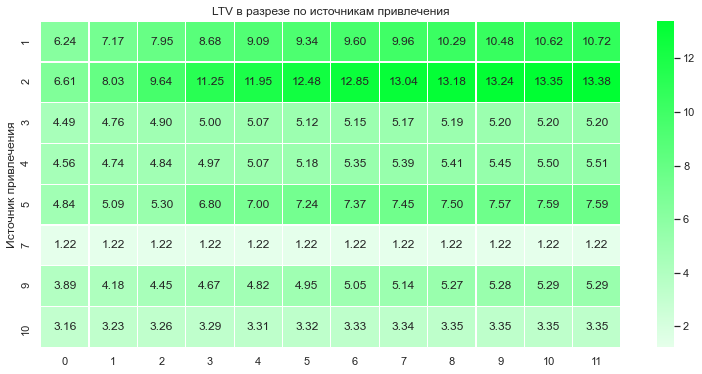

In [77]:
plt.figure(figsize = (13, 6))
cmap2 = sns.light_palette("#00ff33", as_cmap=True)
sns.heatmap(ltv_source, fmt = '.2f', cmap = cmap2, linecolor = 'white', linewidth = 0.2, annot = True)
plt.title('LTV в разрезе по источникам привлечения')
plt.ylabel('Источник привлечения');

Оценка LTV показывает, что на 6 период (условная граница для оценки, после которой количество пользователей начинает сокращаться) наибольшая прибыль была получена от клиентов, пришедших с источников **2, 1 и 5** (12.85, 9.6 и 7.37 соответственно).

Наиболее крупные когорты **3 и 4** демонстрируют относительно низкую LTV (5.15 и 5.35 соответственно).

Рассмотрим аналогичный показатель, но теперь выделим когорты по дате первой покупки, сгруппировав пользователей по месяцам.

In [78]:
ltv_time_prep = order_complex.copy().groupby(['first_order_month', 'lifetime']).agg({'revenue':'sum'}).reset_index()
ltv_time_prep['first_order_month'] = ltv_time_prep['first_order_month'].dt.strftime('%Y-%m-%d')
#ltv_time = ltv_time.cumsum(axis = 1)
#ltv_time_prep = ltv_time_prep.join(cohort_sizes_period, on = 'first_order_month')
#display(ltv_time_prep.info())

In [79]:
#формируем промежуточную таблицу, к которой добавляем размеры когорт (к предыдущей таблице когорты отказывались цепляться Т_Т)
ltv_time_prep2 = ltv_time_prep.merge(cohort_sizes_period, on = 'first_order_month')
ltv_time_prep2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_order_month  79 non-null     object 
 1   lifetime           79 non-null     int64  
 2   revenue            79 non-null     float64
 3   uid                79 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ KB


''

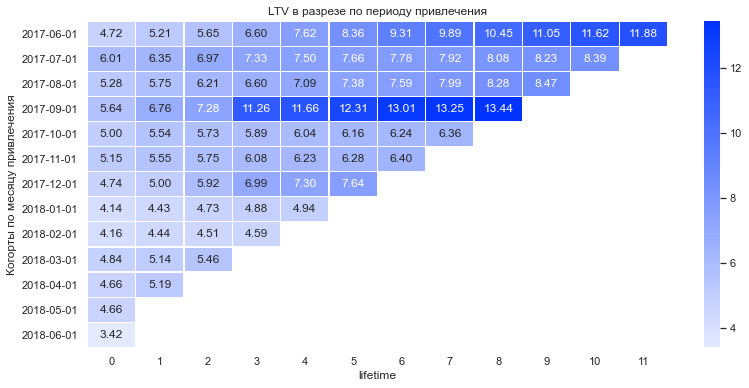

In [80]:
#рассчитываем ltv как выручка по когорте, делённая на количество клиентов в когорте
ltv_time_prep2['ltv'] = ltv_time_prep2['revenue']/ltv_time_prep2['uid']
#формируем сводную для тепловой карты
ltv_time = ltv_time_prep2.pivot_table(index = 'first_order_month', columns = 'lifetime', values = 'ltv',
                                      aggfunc = 'sum'
)
#делаем суммы кумулятивными
ltv_time = ltv_time.cumsum(axis = 1)
#задаём размер поля для тепловой карты
plt.figure(figsize = (13, 6))
cmap3 = sns.light_palette("#0033ff", as_cmap=True)
sns.heatmap(ltv_time, fmt = '.2f', cmap = cmap3, linecolor = 'white', linewidth = 0.2, annot = True)
plt.title('LTV в разрезе по периоду привлечения')
plt.ylabel('Когорты по месяцу привлечения');

Мы видим, что в более поздних когортах LTV даже на ранних периодах снижается по сравнению с когортами пользователей в 2017 году. 
Наиболее прибыльные когорты - 06-2017 и 09-2017. В когорте 09-2017 мы видим резкий скачок из-за повышенного спроса в декабре 2017 года.


2) Рассмотрим расходы на привлечение клиентов <a index=info18> </a>


In [81]:
cohort_sizes_source = cohort_sizes_source.reset_index()
cac_source = costs.groupby('source_id').agg({'costs' : 'sum'}).reset_index()
display(cac_source.sort_values('costs', ascending = False))
#добавляем количество клиентах в когортах к совокупным расходам по источникам
cac_source = cac_source.merge(cohort_sizes_source, left_on = 'source_id', right_on = 'first_source')
#display(cac_source)

,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


,source_id,cac
2,3,13.493901
1,2,12.209367
4,5,7.467479
0,1,7.186364
3,4,5.931779
5,9,5.071222
6,10,4.381106


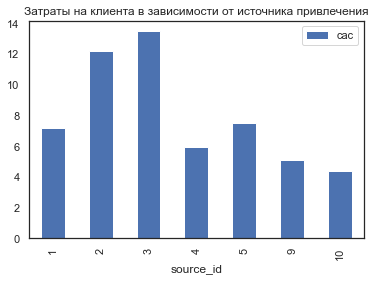

In [82]:
cac_source = cac_source.drop(columns = 'first_source')
#делаем расчет затрат на одного клиента
cac_source['cac'] = cac_source['costs']/cac_source['source_users']
display(cac_source[['source_id', 'cac']].sort_values('cac', ascending = False))
cac_source.plot(kind = 'bar', x = 'source_id', y = 'cac')
plt.title('Затраты на клиента в зависимости от источника привлечения')
plt.show()

Наибольшие затраты на одного клиента приходятся на источники **3, 2 и 5**. Наименьшие затраты - источники **9 и 10**. 
С учетом среднего чека 4.84 нужно не мене 2х покупок, чтобы перекрыть привлечение клиента.

Подсчитаем расходы на пользователя по месяцу привлечения.

In [83]:
costs['period'] = costs['dt'].astype('datetime64[M]')
cac_period = costs.groupby('period').agg({'costs': 'sum'}).reset_index()
cac_period.columns = ['period', 'costs']
cac_period['period'] = cac_period['period'].dt.strftime('%Y-%m-%d')
display(cac_period)

,period,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [84]:
cac_period = cac_period.merge(cohort_sizes_period, left_on = 'period' ,right_on = 'first_order_month')
display(cac_period)

,period,costs,first_order_month,uid
0,2017-06-01,18015.00,2017-06-01,2023
1,2017-07-01,18240.59,2017-07-01,1923
2,2017-08-01,14790.54,2017-08-01,1370
3,2017-09-01,24368.91,2017-09-01,2581
4,2017-10-01,36322.88,2017-10-01,4340
5,2017-11-01,37907.88,2017-11-01,4081
6,2017-12-01,38315.35,2017-12-01,4383
7,2018-01-01,33518.52,2018-01-01,3373
8,2018-02-01,32723.03,2018-02-01,3651
9,2018-03-01,30415.27,2018-03-01,3533


,period,cac
0,2017-06-01,8.91
1,2017-07-01,9.49
2,2017-08-01,10.80
3,2017-09-01,9.44
4,2017-10-01,8.37
5,2017-11-01,9.29
6,2017-12-01,8.74
7,2018-01-01,9.94
8,2018-02-01,8.96
9,2018-03-01,8.61


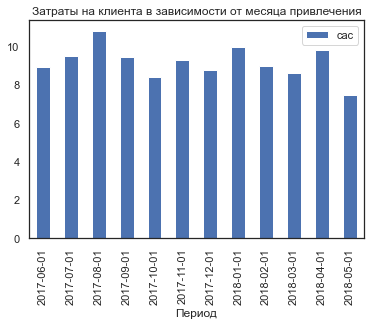

In [85]:
cac_period = cac_period.drop(columns = 'first_order_month')
#подсчитаем расходы на пользователя
cac_period['cac'] = (cac_period['costs']/cac_period['uid']).round(2)
display(cac_period[['period', 'cac']])
cac_period.plot(kind = 'bar', x = 'period', y = 'cac')
plt.title('Затраты на клиента в зависимости от месяца привлечения')
plt.xlabel('Период')
plt.show()

Затраты на привлечения одного клиента меняются циклически. Наибольшая стоимость одного клиента приходится на август 2017, апрель 2018 и январь 2018.

3) Переходим к расчету ROI - return of investments <a index=info19> </a>

In [86]:
cac_source = cac_source.rename(columns = {'source_id': 'first_source'})
cac_source

,first_source,costs,source_users,cac
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106


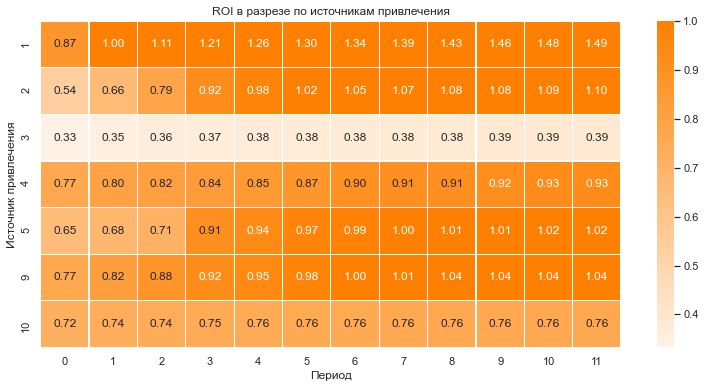

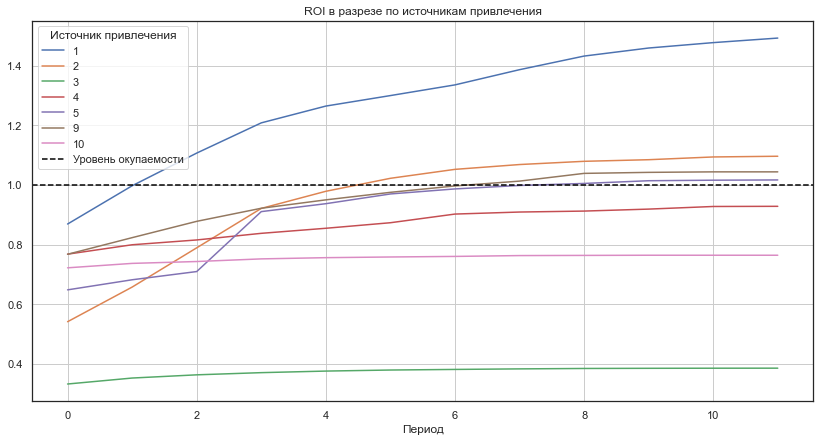

In [87]:
#добавляем к ltv по источникам информацию по затратам
roi_source = ltv_source.merge(cac_source[['cac']], left_on = ltv_source.index ,right_on = cac_source['first_source'], how = 'inner')
#удаляем ненужные столбцы 
roi_source.index = roi_source['key_0']
#делим ltv на затраты на пользователя
roi_source = roi_source.div(roi_source['cac'], axis = 0).drop(columns = ['cac', 'key_0'])
#display(roi_source)
plt.figure(figsize = (13, 6))
cmap2 = sns.light_palette("#ff8000", as_cmap=True)
#устанавливаем самый яркий цвет тепловой карты на уровне окупаемости затрат - 1
sns.heatmap(roi_source, fmt = '.2f', cmap = cmap2, linecolor = 'white', linewidth = 0.2, annot = True, vmax = 1)
plt.title('ROI в разрезе по источникам привлечения')
plt.ylabel('Источник привлечения')
plt.xlabel('Период');
plt.show()
roi_source.T.plot(figsize = (14,7), grid = True)
plt.axhline(y = 1, label = 'Уровень окупаемости',linestyle = 'dashed', color = 'black')
plt.legend(title = 'Источник привлечения')
plt.title('ROI в разрезе по источникам привлечения')
plt.xlabel('Период')
plt.show();

Анализ окупаемости по источникам показал следующее:

- наиболее быстро окупается привлечение из источника 1
- привлечение из источников 3, 4 и 10 не окупается в рассматриваемом периоде
- в течение полугода окупаются источники 1, 2, 9.

Рассмотрим окупаемость в зависимости от месяца привлечения

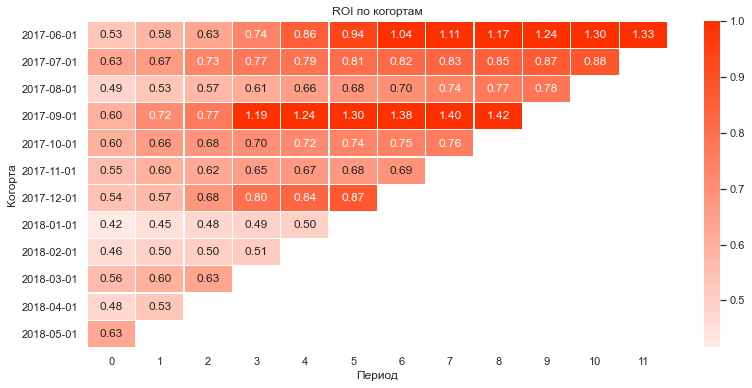

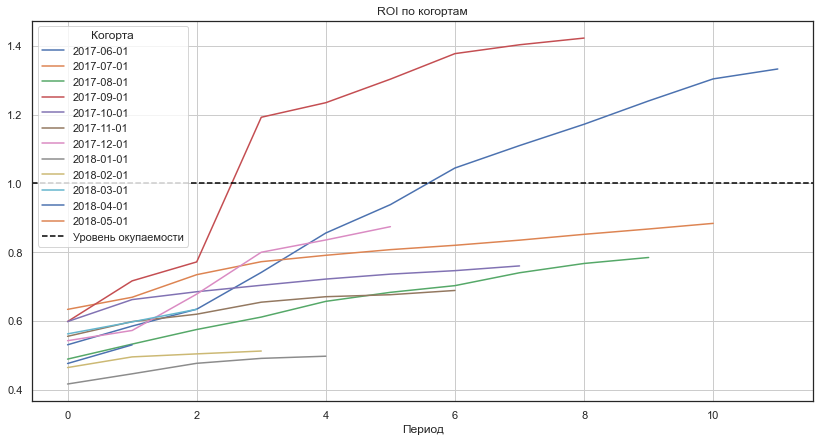

In [88]:
roi_period = ltv_time.merge(cac_period, left_on = 'first_order_month', right_on = 'period')
#display(roi_period)
roi_period.index = roi_period['period']
roi_period = roi_period.drop(columns = ['uid', 'costs', 'period'])
roi_period = roi_period.div(roi_period['cac'], axis = 0).drop(columns = 'cac')
#roi_period = roi_period.fillna(0)
plt.figure(figsize = (13, 6))
cmap2 = sns.light_palette("#ff3000", as_cmap=True)
sns.heatmap(roi_period, fmt = '.2f', cmap = cmap2, linecolor = 'white', linewidth = 0.2, annot = True, vmax = 1)
plt.title('ROI по когортам')
plt.ylabel('Когорта')
plt.xlabel('Период');
plt.show()
roi_period.T.plot(figsize = (14,7), grid = True)
plt.axhline(y = 1, label = 'Уровень окупаемости',linestyle = 'dashed', color = 'black')
plt.legend(title = 'Когорта')
plt.title('ROI по когортам')
plt.xlabel('Период')
plt.show();

Рассматривая когорты по периоду привлечения, мы видим следующее: 

- затраты довольно быстро окупились по клиентам, привлеченным в июне и сентябре 2017 года. 
- оложительный тренд отмечается у пользователей, пришедших в декабре 2017 года.
- привлечение клиентов в 2018 году окупается медленнее

#### Итоги по бизнес-показателям <a index=info20></a>

- на 6 период наибольшая прибыль была получена от клиентов, пришедших с источников **2, 1 и 5** (12.85, 9.6 и 7.37 соответственно).
- наиболее крупные когорты **3 и 4** демонстрируют относительно низкую LTV (5.15 и 5.35 соответственно).
- наиболее затратными по привлечению оказались источники **3, 2 и 5** (13.49, 12.2, 7.46 соответственно)
- наиболее быструю окупаемость вложений показали клиенты источников **1, 2, 5, 9**
- наиболее многочисленные когорты **3 и 4** **не окупаются** в течение года
- окупаемость более поздних когорт снижается относительно более ранних когорт

Мы рассмотрели основные метрики. Перейдём к общим выводам.

### Общий вывод <a index=info21> </a>

В рамках данного проекта было исследовано поведение пользователей сервиса "Яндекс.Афиша" за период с июня 2017 года по июль 2018 года.

Были выявлены следующие характеристики исследуемого сервиса.

Посещаемость сайта:

- Среднее кол-во активных пользователей в день : **907**
- Среднее кол-во активных пользователей в неделю : **5716**
- Среднее кол-во активных пользователей в месяц : **23228**
- уникальные пользователи заходят на сайт не чаще **раза** в сутки
- пользователи предпочитают заходить на сайт с персонального компьютера
- Основные каналы привлечения - **3,4,5** (оттуда приходи больше всего клиентов)
- В среднем, клиент проводит на сайте **10,75** минут (медианное значение - 5 минут)
- Дольше всего задерживаются на сайте клиенты, пришедшие от источников **1,2 и 10**.

Покупки:

- среднее кол-во покупок на клиента в месяц **1.2**
- количество покупок на клиента существенно не отличается на портативных устройствах и ПК
- 97% пользователей не остаётся после первой покупки
- клиенты, продолжавшие покупать в следующих периодах, долгое время оставались лояльными
- Средний лаг между первым посещением и первой покупкой составляет **252** минуты. (без выбросов - **62** минуты)
- медианный лаг составляет 960 секунд - **16** минут. (без выбросов - **9** минут)
- лаг между покупкой и первым посещением на мобильных устройствах больше на 78 минут, чем на ПК
- лаг показывает. что клиент чаще всего **не** совершает покупку в первое посещение
- наибольшую долю в совокупной выручке занимают клиенты с каналов **3 и 4** (около 22% каждый), однако с каналов 2 и 5 приходит такой же доход (около 20%)
- Средняя выручка на одну продажу: **4.84**
- наиболее дорогие покупки клиенты совершают в **декабре, марте и июле**. Наименее дорогие в **январь, июне**.
- более дорогие покупки совершают клиенты с каналами привлечения **1, 2 и 5**

Финансы:

- на 6 период наибольшая прибыль была получена от клиентов, пришедших с источников **2, 1 и 5** (12.85, 9.6 и 7.37 соответственно).
- наиболее крупные когорты **3 и 4** демонстрируют относительно низкую LTV (5.15 и 5.35 соответственно).
- наиболее затратными по привлечению оказались источники **3, 2 и 5** (13.49, 12.2, 7.46 соответственно)
- наиболее быструю окупаемость вложений показали клиенты источников **1, 2, 5, 9**
- наиболее многочисленные когорты **3 и 4** **не окупаются** в течение года
- окупаемость более поздних когорт снижается относительно более ранних когорт

Зафиксированные тенденции:

- снижение лояльности клиентов в когортах с 2018г.
- снижение темпов окупаемости в когортах с 2018г.

Исходя из полученных данных, предлагаем рассмотреть следующие рекомендации:

- сократить расходы и привлечение клиентов с каналов **3 и 4**, поскольку привлечение клиентов с данных источников не окупается в течение календарного года
- проанализировать клиентов, относящихся к каналам привлечения **2, 1 и 5** для определения их характеристик и формирования плана привлечения
- обратить внимание на различие активности клиентов по месяцам продаж для:
  - а) уменьшения влияния сезонности
  - б) максимизации дохода в наиболее "активных" периодах (декабрь, март, июль)
- разработать мероприятия для повышения лояльности
- разработать мероприятия для стимулирования повторных покупок